# データ収集

データ収集方法はなんでも良い。

スクレイピングで大量に集めてもいいし、手動で数十枚集めてデータを加工して擬似的に増やす方法でも良い。

今回は手動で集めて加工する方法で行う。集めるのは大体30枚くらい。

30枚のうち5枚をテストデータにする。


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データの前処理

[ImageDataGenerator](https://keras.io/ja/preprocessing/image/#imagedatagenerator_2
)でデータを増やす

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGeneratorのインスタンスを生成

gen = ImageDataGenerator(
    featurewise_std_normalization=True,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    fill_mode="constant",
    validation_split=0.1
)

# ラベル付けと正規化されたデータのバッチの生成
# バッチサイズは32
# subsetはvalidation_splitがImageDataGeneratorクラスでvalidation_splitが与えられた時に選択可能
train = gen.flow_from_directory(
    "/content/drive/MyDrive/GeekSalon【メンター共有】/01 拠点別/03 東京（使用中)/【使用中】AIメンター共有/05_Contents/Contents_00_教材関連ファイル/train_data",
    class_mode='categorical',
    subset = "training"
)

validation = gen.flow_from_directory(
    "/content/drive/MyDrive/GeekSalon【メンター共有】/01 拠点別/03 東京（使用中)/【使用中】AIメンター共有/05_Contents/Contents_00_教材関連ファイル/train_data",
    class_mode='categorical',
    subset = "validation"
)

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 77 images belonging to 3 classes.
Found 6 images belonging to 3 classes.


対応ラベルの確認

参考：https://github.com/keras-team/keras-preprocessing/blob/3e380065d4afc7347aaee8d89325a16b22158438/keras_preprocessing/image/directory_iterator.py#L12

119行目

In [ ]:
label_dic = train.class_indices

In [ ]:
label_dic

{'basketball': 0, 'golfball': 1, 'tennisball': 2}

# モデルの導入

In [ ]:
# 必要なモジュールのインポート
# tensorflow.kerasから導入
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import experimental
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras import Model

In [ ]:
# 今回は好きなものを公式ドキュメントのApplicationsから選択
# https://keras.io/ja/applications
# include_topをFlaseにして転移学習可能にする
ResNet50 = ResNet50(weights='imagenet',include_top=False, input_tensor=Input(shape=(256,256,3
)))

94765736/94765736 [==============================] - 1s 0us/step


# 転移学習用に再構築

In [ ]:
# 追加層
inputs = ResNet50.output
x = Flatten()(inputs)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.25)(x)

prediction = Dense(3,activation='softmax')(x)

In [ ]:
# 既存層と追加層を繋げる
model=Model(inputs=ResNet50.input,outputs=prediction)

In [ ]:
# モデルの構造を確認
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# コンパイル

kerasのoptimizersから好きなものを選択

https://keras.io/ja/optimizers/

普通のoptimizersだとエラー吐かれるので以下参考

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD

In [ ]:
model.compile(optimizer=experimental.SGD(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# 学習

In [ ]:
history = model.fit(
        train,
        epochs=10,
        verbose=1,
        validation_data=validation
)

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
3/3 [==============================] - 47s 8s/step - loss: 18.5694 - accuracy: 0.4675 - val_loss: 2.4137 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 2s 715ms/step - loss: 3.0667 - accuracy: 0.5714 - val_loss: 2.7180 - val_accuracy: 0.3333
Epoch 3/10
3/3 [==============================] - 2s 547ms/step - loss: 1.0575 - accuracy: 0.6753 - val_loss: 1.1109 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 2s 979ms/step - loss: 0.1839 - accuracy: 0.9481 - val_loss: 0.4118 - val_accuracy: 0.8333
Epoch 5/10
3/3 [==============================] - 2s 592ms/step - loss: 0.0536 - accuracy: 0.9740 - val_loss: 0.1499 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 2s 739ms/step - loss: 0.0954 - accuracy: 0.9610 - val_loss: 0.0917 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 2s 476ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 8/10
3/3 [=====

# 分析

In [ ]:
import matplotlib.pyplot as plt

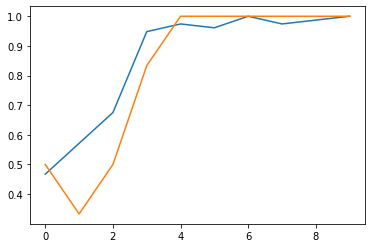

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# テスト

In [ ]:
import os
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

In [ ]:
# パスの名前からテニスかゴルフかバスケか判断する関数の作成
def get_label(path):
  if "golf" in path:
    return "golfball"
  elif "tennis" in path:
    return "tennisball"
  elif "basket" in path:
    return "basketball"
  else:
    pass

In [ ]:
# テストデータで精度を確認
root_path = "/content/drive/MyDrive/GeekSalon【メンター共有】/01 拠点別/03 東京（使用中)/【使用中】AIメンター共有/05_Contents/Contents_00_教材関連ファイル/test_data"
test_img_list = os.listdir(root_path)
true_num = 0
false_num = 0
for path in test_img_list:
  input = image.load_img(os.path.join(root_path,path),target_size=(256,256))
  input = np.expand_dims(input,axis=0)
  input = preprocess_input(input)
  result = model.predict(input)
  predict_label = list(label_dic.keys())[np.argmax(result[0])]
  acc_label = get_label(path)
  print(predict_label, acc_label)
  # 正答率計算
  if predict_label == acc_label:
    true_num += 1

print("正答率は{}".format(true_num/(len(test_img_list))))

1/1 [==============================] - 2s 2s/step
golfball golfball
1/1 [==============================] - 0s 27ms/step
tennisball golfball
1/1 [==============================] - 0s 27ms/step
golfball golfball
1/1 [==============================] - 0s 27ms/step
golfball golfball
1/1 [==============================] - 0s 28ms/step
tennisball golfball
1/1 [==============================] - 0s 27ms/step
basketball basketball
1/1 [==============================] - 0s 33ms/step
basketball basketball
1/1 [==============================] - 0s 26ms/step
basketball basketball
1/1 [==============================] - 0s 42ms/step
basketball basketball
1/1 [==============================] - 0s 49ms/step
basketball basketball
1/1 [==============================] - 0s 44ms/step
tennisball tennisball
1/1 [==============================] - 0s 48ms/step
tennisball tennisball
1/1 [==============================] - 0s 45ms/step
tennisball tennisball
1/1 [==============================] - 0s 38ms/step
tenn

# モデル保存

In [ ]:
model

[Savedmodel](https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ja#savedmodel_%E5%BD%A2%E5%BC%8F)形式で保存


In [ ]:
# モデルが良ければ保存
model.save("/content/drive/MyDrive/GeekSalon【メンター共有】/01 拠点別/03 東京（使用中)/【使用中】AIメンター共有/05_Contents/Contents_00_教材関連ファイル/ball")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/GeekSalon【メンター共有】/01 拠点別/03 東京（使用中)/【使用中】AIメンター共有/05_Contents/Contents_00_教材関連ファイル/ball")

In [ ]:
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7efc762988e0>>

In [ ]:
# テストデータで精度を確認
root_path = "/content/drive/MyDrive/GeekSalon【メンター共有】/01 拠点別/03 東京（使用中)/【使用中】AIメンター共有/05_Contents/Contents_00_教材関連ファイル/test_data"
test_img_list = os.listdir(root_path)
true_num = 0
false_num = 0
for path in test_img_list:
  input = image.load_img(os.path.join(root_path,path),target_size=(256,256))
  input = np.expand_dims(input,axis=0)
  input = preprocess_input(input)
  result = model.predict(input)
  predict_label = list(label_dic.keys())[np.argmax(result[0])]
  acc_label = get_label(path)
  print(predict_label, acc_label)
  # 正答率計算
  if predict_label == acc_label:
    true_num += 1

print("正答率は{}".format(true_num/(len(test_img_list))))

1/1 [==============================] - 2s 2s/step
golfball golfball
1/1 [==============================] - 0s 43ms/step
tennisball golfball
1/1 [==============================] - 0s 33ms/step
golfball golfball
1/1 [==============================] - 0s 30ms/step
golfball golfball
1/1 [==============================] - 0s 31ms/step
tennisball golfball
1/1 [==============================] - 0s 30ms/step
basketball basketball
1/1 [==============================] - 0s 32ms/step
basketball basketball
1/1 [==============================] - 0s 30ms/step
basketball basketball
1/1 [==============================] - 0s 31ms/step
basketball basketball
1/1 [==============================] - 0s 29ms/step
basketball basketball
1/1 [==============================] - 0s 29ms/step
tennisball tennisball
1/1 [==============================] - 0s 30ms/step
tennisball tennisball
1/1 [==============================] - 0s 39ms/step
tennisball tennisball
1/1 [==============================] - 0s 32ms/step
tenn

In [ ]:
model.save("/content/drive/MyDrive/GeekSalon【メンター共有】/01 拠点別/03 東京（使用中)/【使用中】AIメンター共有/05_Contents/Contents_00_教材関連ファイル/ball.h5")

In [ ]:
modelh5 = load_model("/content/drive/MyDrive/GeekSalon【メンター共有】/01 拠点別/03 東京（使用中)/【使用中】AIメンター共有/05_Contents/Contents_00_教材関連ファイル/ball.h5")

In [ ]:
# テストデータで精度を確認
root_path = "/content/drive/MyDrive/GeekSalon【メンター共有】/01 拠点別/03 東京（使用中)/【使用中】AIメンター共有/05_Contents/Contents_00_教材関連ファイル/test_data"
test_img_list = os.listdir(root_path)
true_num = 0
false_num = 0
for path in test_img_list:
  input = image.load_img(os.path.join(root_path,path),target_size=(256,256))
  input = np.expand_dims(input,axis=0)
  input = preprocess_input(input)
  result = modelh5.predict(input)
  predict_label = list(label_dic.keys())[np.argmax(result[0])]
  acc_label = get_label(path)
  print(predict_label, acc_label)
  # 正答率計算
  if predict_label == acc_label:
    true_num += 1

print("正答率は{}".format(true_num/(len(test_img_list))))

1/1 [==============================] - 2s 2s/step
golfball golfball
1/1 [==============================] - 0s 43ms/step
tennisball golfball
1/1 [==============================] - 0s 28ms/step
golfball golfball
1/1 [==============================] - 0s 27ms/step
golfball golfball
1/1 [==============================] - 0s 27ms/step
tennisball golfball
1/1 [==============================] - 0s 28ms/step
basketball basketball
1/1 [==============================] - 0s 32ms/step
basketball basketball
1/1 [==============================] - 0s 27ms/step
basketball basketball
1/1 [==============================] - 0s 28ms/step
basketball basketball
1/1 [==============================] - 0s 28ms/step
basketball basketball
1/1 [==============================] - 0s 27ms/step
tennisball tennisball
1/1 [==============================] - 0s 26ms/step
tennisball tennisball
1/1 [==============================] - 0s 31ms/step
tennisball tennisball
1/1 [==============================] - 0s 28ms/step
tenn